In [1]:
import pandas as pd
raw_df = pd.read_csv('../clean_data/concatenated_data.csv')

In [85]:
raw_df["time"] = pd.to_datetime(raw_df["time"])

df_January = raw_df[raw_df["time"].dt.month == 1]
df_August = raw_df[raw_df["time"].dt.month == 8]

In [86]:
import numpy as np

# Create the numpy array
array_January = df_January.pivot_table(index='time', columns=['lon', 'lat'], values='dis24').to_numpy()
array_August = df_August.pivot_table(index='time', columns=['lon', 'lat'], values='dis24').to_numpy()

In [87]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')
imputed_array_January = imputer.fit_transform(array_January)
array_January = imputed_array_January

imputed_array_August = imputer.fit_transform(array_August)
array_August = imputed_array_August

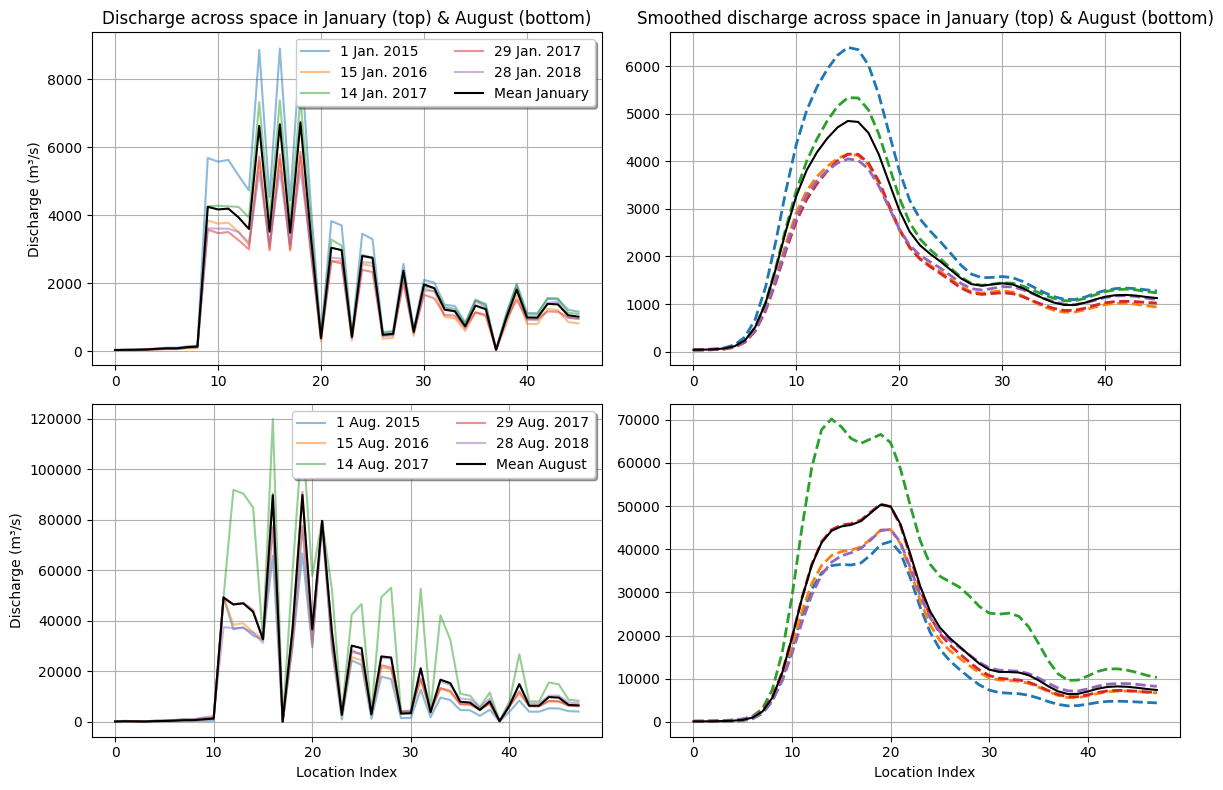

In [139]:
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
indexes = [0, 45, 75, 90, 120]

def index_to_day(index, n_days_month, name_month):
    _year = 2015 + index // n_days_month
    _day = index % n_days_month + 1
    return f"{_day} {name_month} {_year}"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for index in indexes:
    axs[0,0].plot(array_January[index, :], label=index_to_day(index, 31, "Jan."), alpha=0.5)

axs[0,0].plot(array_January.mean(axis=0), label="Mean January", color="black")

# Apply Gaussian filter to smooth the data
smoothed_array_January = gaussian_filter1d(array_January, sigma=2, axis=1)
smoothed_array_January_mean = gaussian_filter1d(array_January.mean(axis=0), sigma=2)
for index in indexes:
    axs[0,1].plot(smoothed_array_January[index, :], linestyle='dashed', alpha=1, linewidth = 2)

axs[0,1].plot(smoothed_array_January_mean, label="Smoothed January", color="black")

axs[0,0].set_ylabel("Discharge (m³/s)")
axs[1,0].set_xlabel("Location Index")
axs[0,0].set_title("Discharge across space in January (top) & August (bottom)")
axs[0,0].legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

for index in indexes:
    axs[1,0].plot(array_August[index, :], label=index_to_day(index, 31, "Aug."), alpha=0.5)

axs[1,0].plot(array_August.mean(axis=0), label="Mean August", color="black")

# Apply Gaussian filter to smooth the data
smoothed_array_August = gaussian_filter1d(array_August, sigma=2, axis=1)
smoothed_array_August_mean = gaussian_filter1d(array_August.mean(axis=0), sigma=2)
for index in indexes:
    axs[1,1].plot(smoothed_array_August[index, :], linestyle='dashed', alpha=1, linewidth = 2, label="Smoothed August")
axs[1,1].plot(smoothed_array_August_mean, label="Smoothed August", color="black")

axs[1,1].set_xlabel("Location Index")
axs[0,1].set_title("Smoothed discharge across space in January (top) & August (bottom)")
axs[1,0].set_ylabel("Discharge (m³/s)")

axs[1,0].legend(loc='best',
          ncol=2, fancybox=True, shadow=True)

axs[0,0].grid()
axs[0,1].grid()
axs[1,0].grid()
axs[1,1].grid()

plt.tight_layout()

plt.show()



In [166]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_january = smoothed_array_January[:-1,:]
y_january = smoothed_array_January[1:,:]

X_august = smoothed_array_August[:-1,:]
y_august = smoothed_array_August[1:,:]


X_train_january, X_test_january, y_train_january, y_test_january = train_test_split(X_january, y_january, test_size=0.2, random_state=42)
X_train_august, X_test_august, y_train_august, y_test_august = train_test_split(X_august, y_august, test_size=0.2, random_state=42)



reg_january = LinearRegression().fit(X_train_january, y_train_january)
reg_august = LinearRegression().fit(X_train_august, y_train_august)

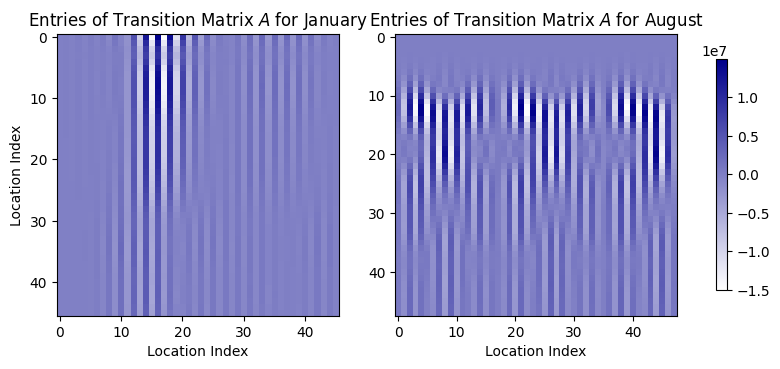

In [167]:
from matplotlib.colors import LinearSegmentedColormap

cmap0 = LinearSegmentedColormap.from_list('', ['white', 'darkblue'])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(reg_january.coef_, cmap=cmap0)
axs[0].set_title('Entries of Transition Matrix $A$ for January')
axs[0].set_xlabel('Location Index')
axs[0].set_ylabel('Location Index')

im = axs[1].imshow(reg_august.coef_, cmap=cmap0)
axs[1].set_title('Entries of Transition Matrix $A$ for August')
axs[1].set_xlabel('Location Index')

fig.colorbar(im, ax=axs.ravel().tolist(), location="right", shrink=0.6)

# fig.tight_layout()
plt.show()

Eigenvalues

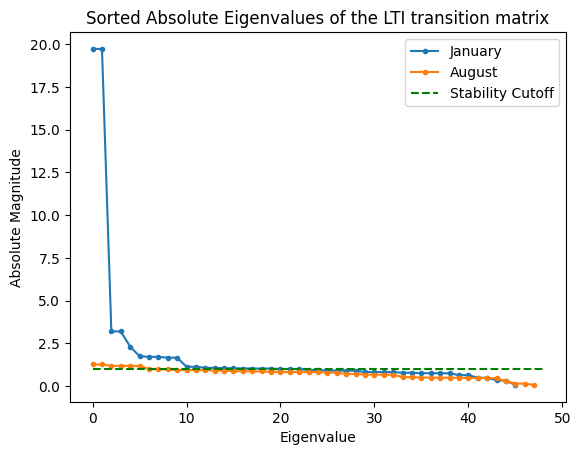

In [168]:
e_values_january = np.linalg.eig(reg_january.coef_)[0]
e_values_august = np.linalg.eig(reg_august.coef_)[0]

plt.plot(np.sort(np.abs(e_values_january))[::-1], '.-', label="January")
plt.plot(np.sort(np.abs(e_values_august))[::-1], '.-', label="August")
plt.hlines(1, 0, len(e_values_august), colors='g', linestyles='dashed', label='Stability Cutoff')
plt.xlabel('Eigenvalue')
plt.ylabel('Absolute Magnitude')
plt.title('Sorted Absolute Eigenvalues of the LTI transition matrix')
plt.legend(loc="best")

Predictions

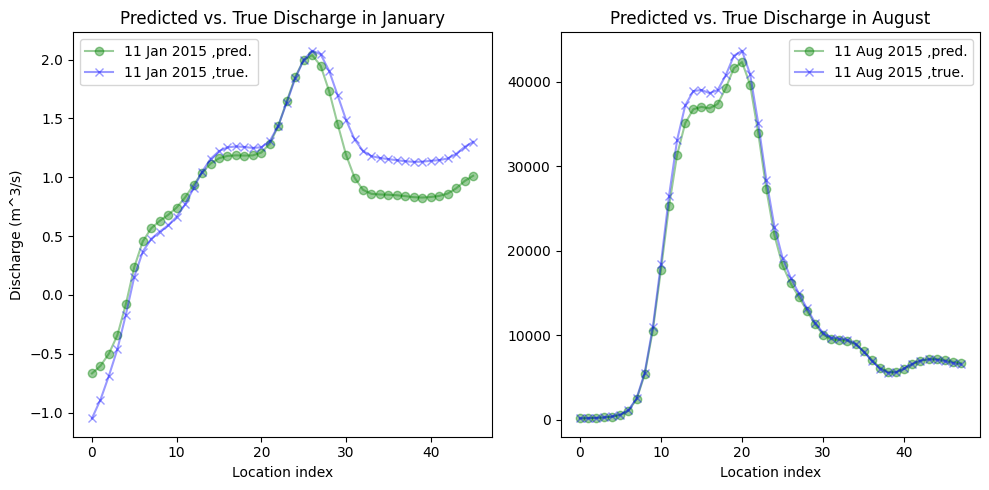

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y_hat_january = reg_january.predict(X_test_january)
y_hat_august = reg_august.predict(X_test_august)

n_locations = y_test_january.shape[1]

sample_indexes = 29

fix, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(y_hat_january[sample_indexes,:], "g-o", label=index_to_day(10, 31, "Jan") + " ,pred.", alpha=0.4)
ax[0].plot(y_test_january[sample_indexes,:], "b-x", label=index_to_day(10, 31, "Jan") + " ,true.", alpha=0.4)
ax[0].set_title("Predicted vs. True Discharge in January")
ax[0].set_ylabel("Discharge (m^3/s)")
ax[0].set_xlabel("Location index")
ax[0].legend()

ax[1].plot(y_hat_august[sample_indexes,:], "g-o", label=index_to_day(10, 31, "Aug") + " ,pred.", alpha=0.4)
ax[1].plot(y_test_august[sample_indexes,:], "b-x", label=index_to_day(10, 31, "Aug") + " ,true.", alpha=0.4)
ax[1].set_title("Predicted vs. True Discharge in August")
ax[1].set_xlabel("Location index")
ax[1].legend()

plt.tight_layout()
plt.show()